In [ ]:
!pip install kaggle

# Assuming you have your kaggle.json file uploaded to your Colab environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

!unzip coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image


In [ ]:

extracted_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
label_info_path = "Chest_xray_Corona_Metadata.csv"

# Check if the file exists at the given path
if os.path.exists(label_info_path):
    df = pd.read_csv(label_info_path)
    df.head()
else:
    print(f"Error: File not found at {label_info_path}")
    print("Please check if the dataset was correctly unzipped.")
    print("The unzipped folder should contain 'Chest_xray_Corona_Metadata.csv'")

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
X_ray_image_name,0
Label,0
Dataset_type,0
Label_2_Virus_category,5841
Label_1_Virus_category,1576


In [ ]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
path_metadata = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv'
path_train = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_test = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
path_fasttext = '../input/fasttext-common-crawl-bin-model/cc.en.300.bin'
path_test_img = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e24-g003-l-a.jpg'

In [ ]:
df1 = df.copy()
df1.Label_1_Virus_category.fillna(df1.Label, inplace=True)
df1.Label_2_Virus_category.fillna(df1.Label_1_Virus_category,
                                          inplace=True)
df1.drop(['Label', 'Label_1_Virus_category'], axis=1, inplace=True)
df1.rename(columns={'X_ray_image_name':  'Filename',
                            'Dataset_type': 'Type',
                            'Label_2_Virus_category': 'Class'}, inplace=True)
df1.Class.replace({'Virus': 'viral pneumonia',
                           'bacteria': 'bacterial pneumonia',
                           'Normal': 'normal',
                           'COVID-19': 'covid-19'}, inplace=True)
df1

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal
...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,TEST,viral pneumonia
5906,5929,person1635_virus_2831.jpeg,TEST,viral pneumonia
5907,5930,person1634_virus_2830.jpeg,TEST,viral pneumonia
5908,5931,person1633_virus_2829.jpeg,TEST,viral pneumonia


In [ ]:
df1.shape

(5910, 4)

In [ ]:
df1['Class'].value_counts()

,count
Class,
bacterial pneumonia,2772
normal,1576
viral pneumonia,1493
covid-19,58
Streptococcus,5
SARS,4
ARDS,2


In [ ]:
# dataframes (training, validation, testing)
df_train = df1[(df1.Type == 'TRAIN')]
df_test = df1[(df1.Type == 'TEST').reset_index(drop=True)]

# df_zsl = df[(df.Class.isin(class_zsl))].reset_index(drop=True)

In [ ]:
df_train.head()

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal


In [ ]:
df_train.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
# df_jsl.drop(['Type','Unnamed: 0'], axis=1, inplace=True)

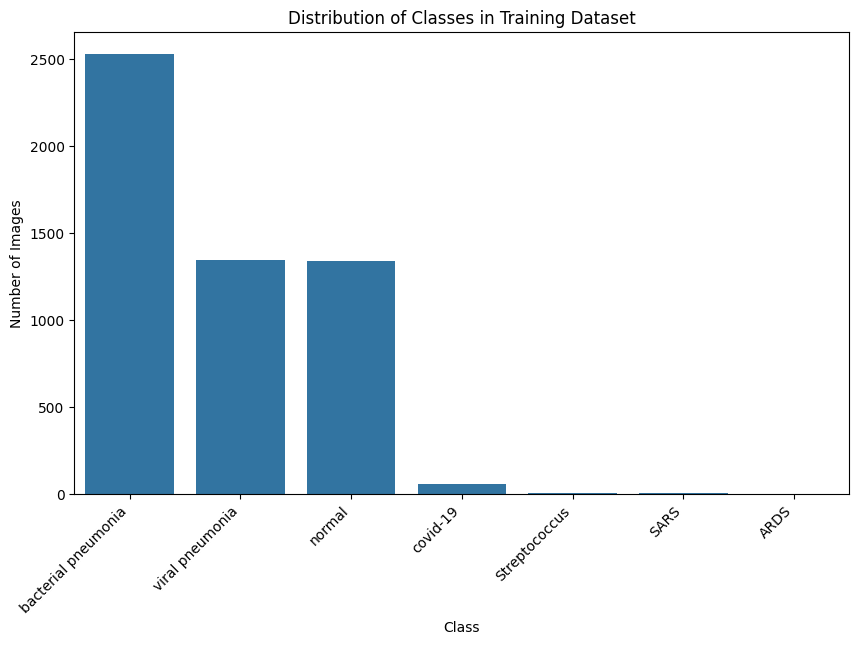

In [ ]:


# Count the occurrences of each class
class_counts = df_train['Class'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# prompt: select bacterial pneumonia,  viral pneumonia, normal from train dataset

import pandas as pd

# Assuming df_train is already defined from the previous code
selected_classes = ['bacterial pneumonia', 'viral pneumonia', 'normal']
df_train = df_train[df_train['Class'].isin(selected_classes)]

df_train

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal
...,...,...
5212,person88_virus_167.jpeg,viral pneumonia
5213,person88_virus_166.jpeg,viral pneumonia
5214,person88_virus_165.jpeg,viral pneumonia
5215,person88_virus_164.jpeg,viral pneumonia


In [ ]:
X_train = df_train['Filename']
y_train = df_train['Class']
X_test = df_test['Filename']
y_test = df_test['Class']

In [ ]:
idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2) )
idg_test = image.ImageDataGenerator(rescale=1/255)

data_train = idg_train.flow_from_dataframe(dataframe=df_train,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')
data_test = idg_test.flow_from_dataframe(dataframe=df_test,
                                          directory=path_test,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          shuffle=True,
                                          class_mode='categorical')

# data_zsl = idg_test.flow_from_dataframe(dataframe=df_zsl,
                                        # directory=path_train,
                                        # x_col='Filename',
                                        # y_col='Class',
                                        # target_size=(224, 224),
                                        # batch_size=1,
                                        # # class_mode=None
                                        # shuffle=False,
                                        # class_mode='categorical')




Found 5217 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: split data train

from sklearn.model_selection import train_test_split

# Assuming df_train is your training dataframe with 'Filename' and 'Class' columns
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train['Filename'], df_train['Class'], test_size=0.2, random_state=42
)  # Adjust test_size as needed

# Create new dataframes for the split data
df_train_split = pd.DataFrame({'Filename': X_train_split, 'Class': y_train_split})
df_val_split = pd.DataFrame({'Filename': X_val_split, 'Class': y_val_split})

# Now you have df_train_split and df_val_split for training and validation, respectively
# You can use these dataframes in your image data generators:

idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2))

idg_val = image.ImageDataGenerator(rescale=1/255) # Use rescale for validation data

data_train_split = idg_train.flow_from_dataframe(dataframe=df_train_split,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')

data_val_split = idg_val.flow_from_dataframe(dataframe=df_val_split,
                                          directory=path_train,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32, #Can adjust batch size
                                          shuffle=False, #Important: No shuffling for validation
                                          class_mode='categorical')



Found 4173 validated image filenames belonging to 3 classes.
Found 1044 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: check how many images are in the train and val

print("Number of images in the training set:", len(df_train_split))
print("Number of images in the validation set:", len(df_val_split))

Number of images in the training set: 4173
Number of images in the validation set: 1044


In [ ]:
data_val_split.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

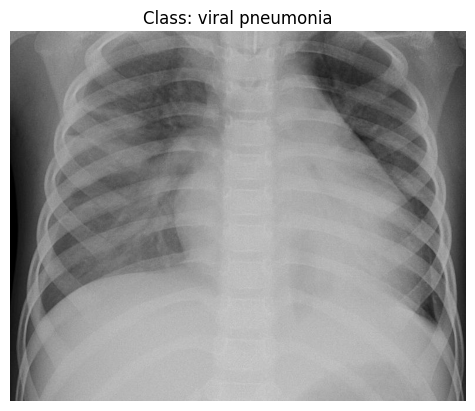

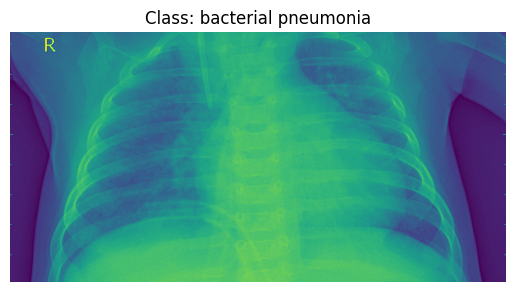

In [ ]:


import random
import matplotlib.pyplot as plt

def load_and_display_random_image(df, path):
  """Loads and displays a random image from the specified dataset."""

  # Choose a random index from the DataFrame
  random_index = random.randint(0, len(df) - 1)

  # Get the filename and class from the DataFrame
  filename = df.iloc[random_index]['Filename']
  class_label = df.iloc[random_index]['Class']

  # Construct the image path
  image_path = os.path.join(path, filename)

  # Load the image using matplotlib
  try:
      img = plt.imread(image_path)
      plt.imshow(img)
      plt.title(f"Class: {class_label}")
      plt.axis('off') # Hide axis ticks and labels
      plt.show()

  except FileNotFoundError:
      print(f"Error: Image file not found at {image_path}")

# Example usage for the training dataset:
load_and_display_random_image(df_train, path_train)

# Example usage for the testing dataset:
load_and_display_random_image(df_test, path_test)

In [ ]:
data_train.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

In [ ]:
# prompt: generate a cnn model

def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

# Create the model
model = create_cnn_model()

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model.summary()

# Train the model (assuming you have 'data_train' and 'data_test' from previous code)
# history = model.fit(data_train, epochs=10, validation_data=data_test) #Example, adjust epochs as needed


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │         559,875 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,267 (2.21 MB)

 Trainable params: 579,267 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
data_train


In [ ]:
# prompt: fit the model

# Train the model (assuming you have 'data_train' and 'data_test' from previous code)
history = model.fit(data_train_split, epochs=10, validation_data = data_val_split) #Example, adjust epochs as needed

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 115s 811ms/step - accuracy: 0.4866 - loss: 1.5730 - val_accuracy: 0.6964 - val_loss: 0.7030
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 742ms/step - accuracy: 0.6928 - loss: 0.7069 - val_accuracy: 0.7050 - val_loss: 0.6618
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 724ms/step - accuracy: 0.7011 - loss: 0.6732 - val_accuracy: 0.7193 - val_loss: 0.6624
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 141s 724ms/step - accuracy: 0.7301 - loss: 0.6425 - val_accuracy: 0.7452 - val_loss: 0.6746
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 736ms/step - accuracy: 0.7158 - loss: 0.6395 - val_accuracy: 0.7452 - val_loss: 0.6640
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 725ms/step - accuracy: 0.7384 - loss: 0.6061 - val_accuracy: 0.7069 - val_loss: 0.7718
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 721ms/step - accuracy: 0.7477 - loss: 0.5957 - val_accuracy: 0.7414 - val_loss: 0.6501
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 734ms/step - accuracy: 0.7511 -

In [ ]:
# prompt: save the model

model.save('my_model.h5')

In [ ]:
# Load the saved model
model = keras.models.load_model('my_model.h5')

# To download the model file from Colab:
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.evaluate(data_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.7652 - loss: 0.7189


[0.7125977873802185, 0.7804487347602844]

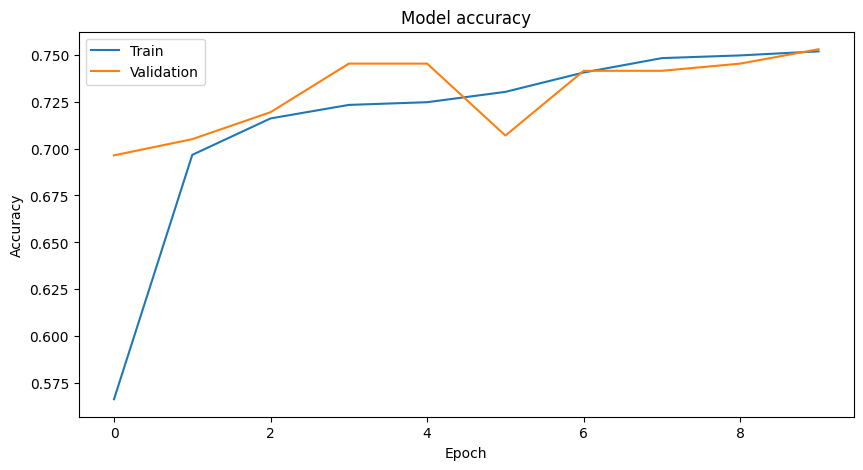

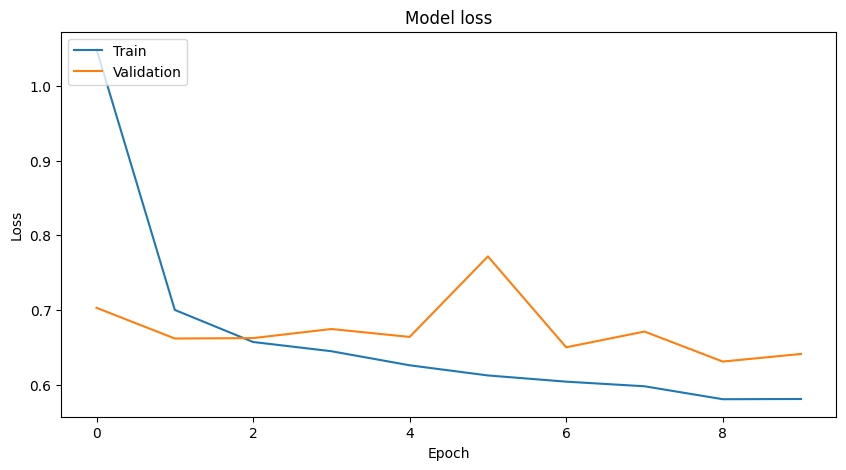

In [ ]:
# prompt: visualize accuracy and loss

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
# prompt: hyperparameter tuning for cnn model

import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(224, 224, 3)))

    # Tune the number of layers
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(layers.Dense(3, activation='softmax'))  # Output layer

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,  # Adjust the number of trials as needed
    executions_per_trial=2, # Adjust the number of executions per trial
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(data_train_split, epochs=10, validation_data = data_val_split, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.
Optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 2 Complete [00h 40m 27s]
val_accuracy: 0.7739463448524475

Best val_accuracy So Far: 0.7739463448524475
Total elapsed time: 01h 14m 22s

The hyperparameter search is complete. The optimal number of layers is 2.
Optimal learning rate for the optimizer is 0.0001.



In [ ]:


import tensorflow as tf
from tensorflow import keras

# Load the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(data_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
predictions = best_model.predict(data_test)

# Get predicted class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Print some example predictions
print("Example Predictions:")
for i in range(10):  # Print the first 10 predictions
    print(f"Image {i+1}: Predicted Label - {predicted_labels[i]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 650ms/step - accuracy: 0.8025 - loss: 0.5538
Test Loss: 0.5748
Test Accuracy: 0.8077
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step
Example Predictions:
Image 1: Predicted Label - 1
Image 2: Predicted Label - 0
Image 3: Predicted Label - 1
Image 4: Predicted Label - 1
Image 5: Predicted Label - 0
Image 6: Predicted Label - 0
Image 7: Predicted Label - 0
Image 8: Predicted Label - 2
Image 9: Predicted Label - 0
Image 10: Predicted Label - 0


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 109s 776ms/step - accuracy: 0.7633 - loss: 0.5722 - val_accuracy: 0.7663 - val_loss: 0.5599
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 740ms/step - accuracy: 0.7681 - loss: 0.5464 - val_accuracy: 0.7672 - val_loss: 0.5450
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 757ms/step - accuracy: 0.7708 - loss: 0.5394 - val_accuracy: 0.7835 - val_loss: 0.5634
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 743ms/step - accuracy: 0.7628 - loss: 0.5540 - val_accuracy: 0.7759 - val_loss: 0.5322
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 731ms/step - accuracy: 0.7777 - loss: 0.5157 - val_accuracy: 0.7807 - val_loss: 0.5313
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 783ms/step - accuracy: 0.7741 - loss: 0.5294 - val_accuracy: 0.7692 - val_loss: 0.5433
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 148s 828ms/step - accuracy: 0.7784 - loss: 0.5385 - val_accuracy: 0.7701 - val_loss: 0.5492
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 135s 772ms/step - accuracy: 0.7807 -

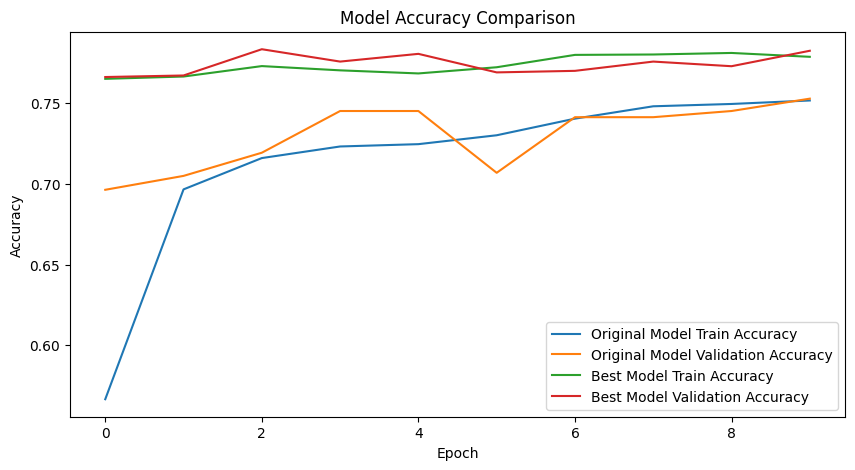

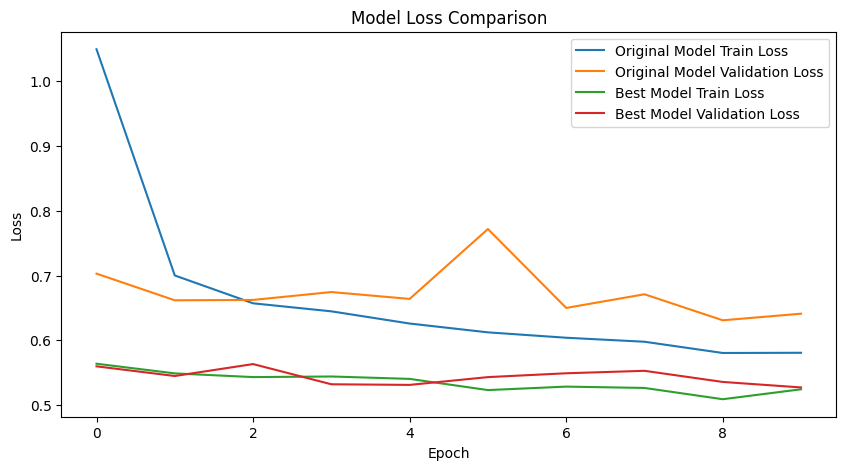

In [ ]:


import matplotlib.pyplot as plt

# Train the best model and get its history
best_model_history = best_model.fit(data_train_split, epochs=10, validation_data = data_val_split)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Original Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Original Model Validation Accuracy')
plt.plot(best_model_history.history['accuracy'], label='Best Model Train Accuracy')
plt.plot(best_model_history.history['val_accuracy'], label='Best Model Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Original Model Train Loss')
plt.plot(history.history['val_loss'], label='Original Model Validation Loss')
plt.plot(best_model_history.history['loss'], label='Best Model Train Loss')
plt.plot(best_model_history.history['val_loss'], label='Best Model Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:

# Save the best model
best_model.save('best_model.h5')

# Download the model file
files.download('best_model.h5')

# Load the saved model
loaded_best_model = keras.models.load_model('best_model.h5')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Load the saved model
model = keras.models.load_model('my_model.h5')

# Load and preprocess the image
img_path = 'test.jpg'  # Replace with the actual path to your image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.  # Normalize the image

# Make the prediction
predictions = loaded_best_model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Get the class labels (assuming you have them stored somewhere)
class_labels = list(data_train.class_indices.keys()) #Get class labels from the training data generator

# Print the prediction
print(f"Predicted class: {class_labels[predicted_class]}")
print(f"Prediction probabilities: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicted class: viral pneumonia
Prediction probabilities: [[0.05554566 0.45652837 0.48792598]]
